# Returning the echo distance

This notebook uses the water tank model from the previous notebook, with a solution to generating source positions and measurement setups and returning a point from the echo.

In [1]:
import math
import os
import time
from enum import Enum
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from devito import ConditionalDimension, Eq, Operator, TimeFunction, solve
from examples.seismic import (Model, Receiver, RickerSource, TimeAxis,
                              WaveletSource, plot_shotrecord, plot_velocity)
from scipy.signal import find_peaks, peak_prominences

plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size

## Grid Setup
Set velocity model and global parameters for water tank.

In [2]:
nx = 601
nz = 301
nb = 10
shape = (nx, nz)
spacing = (.01, .01) #60x30 m 
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
v_obj = 3.24 # v in gold 3240 m/s
glass = 50 # size of the glass
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water
# ellipse formula
a = (int)((nx - 1) / 2)
b = (int)((nz - 1) / 2)
for i in range(nx):
    for j in range(nz):
        if ((i - a)**2 / a**2 + (j+10 - b)**2 / b**2) > 1:
            v[i, j] = v_glass
v[:, :b] = v_water
v[:5,  :15+b] = v_glass
v[-5:, :15+b] = v_glass


model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


## Define the positions of the sources and receivers

In [ ]:
def srcPositions(cx: float, cy:float, alpha:float, ns:int, sdist:float) -> np.typing.NDArray:
    assert alpha >= 0 and alpha < 180
    assert ns > 0
    dx = sdist * math.sin(math.pi / 180 * alpha)
    dy = sdist * math.cos(math.pi / 180 * alpha)

    res = np.zeros((ns, 2))
    res[:, 0] = np.linspace(cx - dx * (ns - 1) / 2, cx + dx * (ns - 1) / 2, num = ns)
    res[:, 1] = np.linspace(cy - dy * (ns - 1) / 2, cy + dy * (ns - 1) / 2, num = ns)
    return res

class SineSource(WaveletSource):
    @property
    def wavelet(self):
        t0 = self.t0 or 1 / self.f0
        a = self.a or 1
        r = (np.pi * self.f0 * (self.time_values - t0))
        wave = a * np.sin(r) + a*np.sin(3*(r+np.pi)/4)
        wave[np.searchsorted(self.time_values, 4*2/self.f0):] = 0
        return wave

def setup_domain(model, tn=0.05, ns=128, f0=5000, posx=0.5, posy=0.0, angle=90):
    # Set time range, source, source coordinates and receiver coordinates
    t0 = 0.  # Simulation starts a t=0
    #tn - Simulation lasts tn milliseconds
    dt = model.critical_dt  # Time step from model grid spacing
    time_range = TimeAxis(start=t0, stop=tn, step=dt)

    #f0 Source peak frequency is 5 MHz (5000 kHz)
    #ns number of sources
    nr = ns; # number of receivers
    depth = 1
    wavelength = v_water / f0 # 0.03 cm
    source_distance = wavelength / 8
    source_angle = angle # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
    #posx and posy are relative positions 0 - left, 1 - right (or top-bottom)
    cx = model.domain_size[0] * posx
    if posy == 0.0:
        cy = (ns - 1) / 2 * source_distance
    else:
        cy = model.domain_size[1] * posy
    pos = srcPositions(cx, cy, source_angle, ns, source_distance)
    src = SineSource(
        name='src',
        grid=model.grid,
        f0=f0,
        time_range=time_range,
        npoint=ns)

    src.coordinates.data[:, -1] = depth
    src.coordinates.data[:] = pos[:]

    rec = Receiver(
        name='rec',
        grid=model.grid,
        npoint=nr,
        time_range=time_range) 

    rec.coordinates.data[:, -1] = depth
    rec.coordinates.data[:] = pos[:]
    return src, rec, time_range

def srcPositions(domain_size: tuple[np.float64, np.float64],
                 posx: float = 0.5,
                 posy: float = 0.0,
                 source_distance: float = .1,
                 ns:int = 128,
                 angle:float = 90) -> np.typing.NDArray:
    angle  # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
    #posx and posy are relative positions 0 - left, 1 - right (or top-bottom)
    cx = domain_size[0] * posx
    if posy == 0.0:
        cy = (ns - 1) / 2 * source_distance
    else:
        cy = domain_size[1] * posy
    return srcPositions(cx, cy, angle, ns, source_distance)

In [3]:

source_angle = 90
src, rec, time_range = setup_domain(model, tn=5, ns=128, f0=50, posx=.5, posy=0.0, angle=source_angle)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

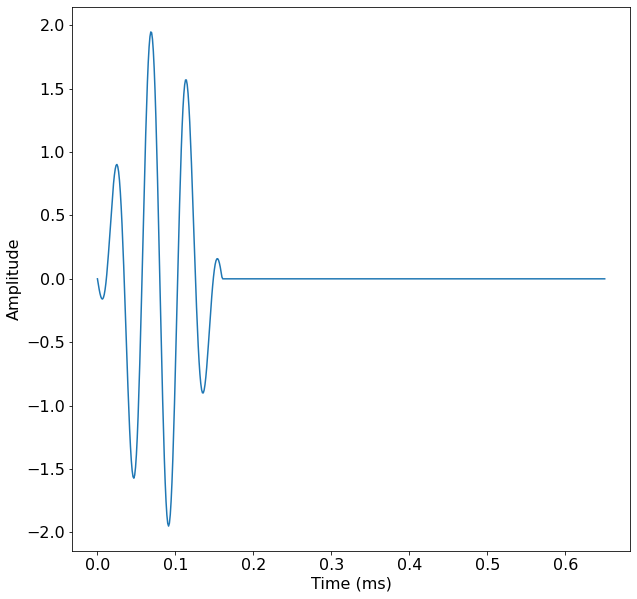

In [6]:
plt.figure()
plt.plot(src.time_values[:600], src.data[:600,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

## Operator and plot velocity profile

Operator `Kernel` ran in 1.90 s


4606


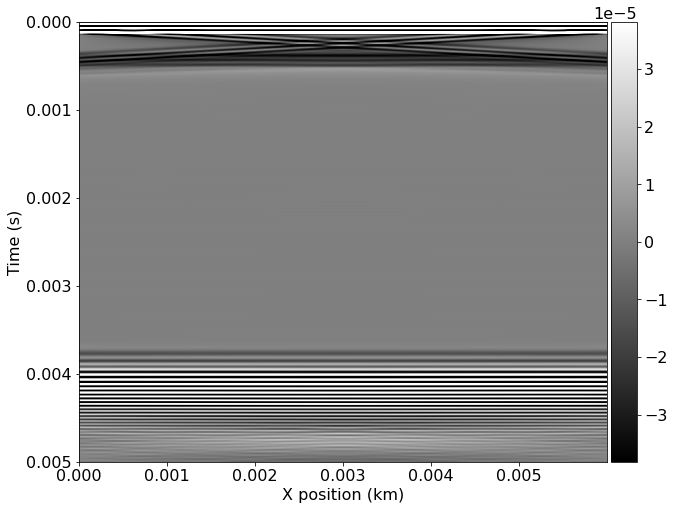

In [7]:
u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * model.critical_dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=time_range.num - 2, dt=model.critical_dt)
print(time_range.num)
plot_shotrecord(rec.data, model, 0.0, 5)

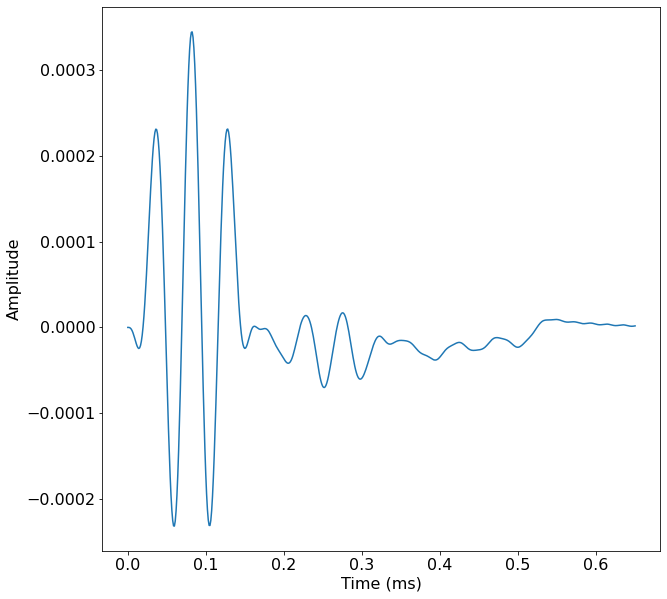

In [8]:
plt.figure()
plt.plot(src.time_values[:600],rec.data[:600,64])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

## Function for calculating the distance

In [9]:
def objDistance(receiver, timestep:float, v_env: float) -> Tuple[float, float]:
    cut = 600
    x = receiver[cut:]
    peaks, _ = find_peaks(x)
    prominences = peak_prominences(x, peaks)[0]
    first_peak = cut + peaks[(prominences - np.average(prominences)) > np.std(prominences)][0]
    distance = (((first_peak * timestep) / 2 ) / 1000 * v_env)
    return distance * 1e4, x[first_peak - cut]

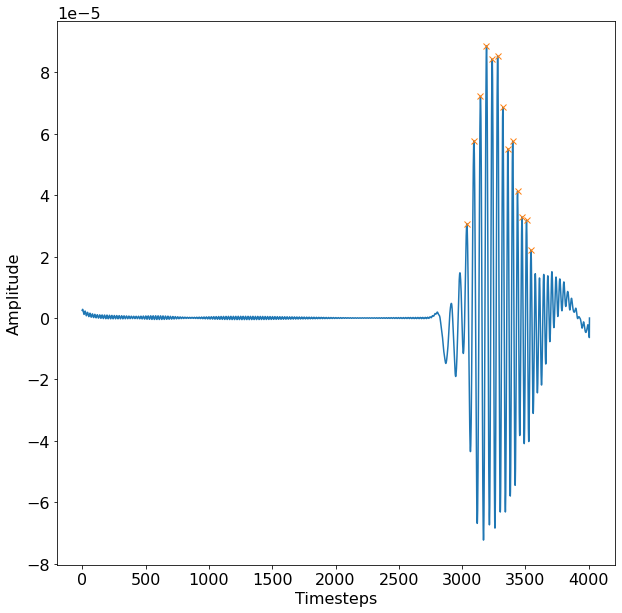

Amplitude of the first peak: 3.0717e-05


In [10]:
cut = 600
avg = np.average(rec.data, axis = 1)
x = avg[cut:]
peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
true_peaks= peaks[(prominences - np.average(prominences)) > np.std(prominences)]
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")
plt.plot(x)
plt.plot(true_peaks, x[true_peaks], "x")
plt.show()
print(f"Amplitude of the first peak: {x[true_peaks][0]:.4e}")

In [11]:
print(objDistance(np.average(rec.data, axis = 1), model.critical_dt, v_water))

(29.623365105071567, 3.0716896e-05)


## Function for position/angle sweep

In [12]:
def run_positions_angles(posx=[0.5], posy=0.0, angle=[90]):
    if np.size(posy) > 1 and np.size(posx) != np.size(posy):
        print(
            "error, posx and posy arrays must be same length, or posy length 1"
        )
        return
    if np.size(posy) == 1:
        posyarr = np.ones(np.shape(posx)) * posy
    distances = np.zeros((np.size(posx), np.size(angle)))
    amplitudes = np.zeros((np.size(posx), np.size(angle)))
    print(np.shape(distances))
    wavelength = v_water / 50
    source_distance = wavelength / 8
    src, rec, time_range = setup_domain(model,
                                        tn=5,
                                        ns=128,
                                        f0=50,
                                        posx=posx[0],
                                        posy=posyarr[0],
                                        angle=angle[0])
    u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)
    # Set symbolics of the operator, source and receivers:
    pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = Eq(u.forward, solve(pde, u.forward))
    src_term = src.inject(field=u.forward,
                          expr=src * model.critical_dt**2 / model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
    #  res = np.zeros((len(angle), rec.data.shape[0], rec.data.shape[1]))
    for i in range(np.size(posx)):
        for j in range(np.size(angle)):
            start = time.time()

            pos = srcPositions(model.domain_size,
                               posx=posx[i],
                               posy=posyarr[i],
                               angle=angle[j],
                               ns=128,
                               source_distance=source_distance)
            src.coordinates.data[:] = pos[:]
            rec.coordinates.data[:] = pos[:]
            u.data.fill(0)

            # Run the operator for `(nt-2)` time steps:
            op(time_m=1, time=time_range.num - 2, dt=model.critical_dt)
            #  res[j] = rec.data
            result = objDistance(np.average(rec.data, axis=1),
                                 model.critical_dt, v_water)
            distances[i, j] = result[0]
            amplitudes[i, j] = result[1]
            print(f"Iteration took: {time.time() - start}")
    return distances, amplitudes#, res

In [13]:
angles = np.arange(5, 175, 1)
results = run_positions_angles(posx=[0.5], angle=angles)
print(results)

(1, 170)


Operator `Kernel` ran in 0.97 s
Operator `Kernel` ran in 0.87 s
Operator `Kernel` ran in 0.96 s
Operator `Kernel` ran in 0.79 s
Operator `Kernel` ran in 0.87 s
Operator `Kernel` ran in 1.07 s
Operator `Kernel` ran in 1.93 s
Operator `Kernel` ran in 1.13 s
Operator `Kernel` ran in 0.63 s
Operator `Kernel` ran in 0.67 s
Operator `Kernel` ran in 0.66 s
Operator `Kernel` ran in 0.78 s
Operator `Kernel` ran in 0.65 s
Operator `Kernel` ran in 0.74 s
Operator `Kernel` ran in 0.75 s
Operator `Kernel` ran in 0.78 s
Operator `Kernel` ran in 0.67 s
Operator `Kernel` ran in 0.63 s
Operator `Kernel` ran in 0.72 s
Operator `Kernel` ran in 0.94 s
Operator `Kernel` ran in 1.16 s
Operator `Kernel` ran in 0.82 s
Operator `Kernel` ran in 0.91 s
Operator `Kernel` ran in 0.83 s
Operator `Kernel` ran in 0.88 s
Operator `Kernel` ran in 0.98 s
Operator `Kernel` ran in 0.73 s
Operator `Kernel` ran in 0.84 s
Operator `Kernel` ran in 0.74 s
Operator `Kernel` ran in 0.88 s
Operator `Kernel` ran in 0.78 s
Operator

(array([[31.04059511, 31.03245011, 31.03245011, 31.62703511, 31.61074511,
        31.59445511, 31.57816511, 31.55373011, 31.53744011, 31.52115011,
        31.49671511, 31.48042511, 31.45599011, 31.45599011, 31.44784511,
        31.45599011, 31.33381511, 31.30938011, 31.30123511, 35.20269012,
        35.21083512, 35.20269012, 35.20269012, 35.19454512, 35.18640012,
        35.17825512, 35.17011012, 35.16196512, 35.13753012, 35.11309512,
        34.62439512, 34.59996012, 34.58367012, 34.57552512, 34.57552512,
        34.56738012, 31.25236511, 31.24422011, 31.24422011, 30.95100011,
        30.96729011, 30.97543511, 30.98358011, 30.99172511, 30.99987011,
        30.98358011, 30.93471011, 30.91842011, 30.92656511, 30.93471011,
        30.95100011, 30.96729011, 30.98358011, 30.99987011, 30.99987011,
        31.42341011, 31.42341011, 31.42341011, 30.99172511, 30.99987011,
        31.42341011, 31.04059511, 31.06503011, 31.07317511, 31.08132011,
        31.08946511, 31.08132011, 31.48042511, 29.

## Function for returning the coordinates of the points

In [14]:
def calculate_coordinates(posx=[0.5], posy=0.0, angle=[65], distance=[26], amplitude=[2.3169e-09]):
    if np.size(posy)>1 and np.size(posx)!=np.size(posy):
        print("error, posx and posy arrays must be same length, or posy length 1")
        return
    if np.size(posy)==1:
        posyarr = np.ones(np.shape(posx)) * posy
    m_size = np.size(posx) * np.size(angle)
    if np.size(amplitude) != np.size(distance):
        print("error, angle and distance arrays must be same length")
        return
    results=np.zeros((m_size, 2))
    idx = 0
    for i in range(np.size(posx)):
        for j in range(np.size(angle)):
            #  calc_angle = abs(90-angle[j])
            calc_angle = 90-angle[j]
            source = model.domain_size[0] * posx[i] * 1e1
            dist_from_source = np.sin(calc_angle * np.pi / 180) * distance[i,j]
            #  if angle[j] < 90:
            #      x_coord = source - dist_from_source
            #      y_coord = math.sqrt(math.pow(distance[i,j], 2) - math.pow(dist_from_source, 2))
            #  elif angle[j] > 90:
            #      x_coord = source + dist_from_source
            #      y_coord = math.sqrt(math.pow(distance[i,j], 2) - math.pow(dist_from_source, 2))
            #  else:
            #      x_coord = source
            #      y_coord = distance[i, j]
            x_coord = source - dist_from_source
            y_coord = math.sqrt(math.pow(distance[i,j], 2) - math.pow(dist_from_source, 2))
            results[idx, 0] = x_coord
            results[idx, 1] = y_coord
            idx += 1
    return results
            


[[-0.92247694  2.70536612]
 [-0.86245177  3.24377432]
 [-0.8011396   3.78190432]
 [-1.31924365  4.40163255]
 [-1.22156506  4.94501   ]
 [-1.11446502  5.48631955]
 [-0.99798595  6.02539796]
 [-0.86420607  6.56038938]
 [-0.72913824  7.0943804 ]
 [-0.58483791  7.62565639]
 [-0.42349124  8.15194973]
 [-0.2609275   8.67718114]
 [-0.08151362  9.19684145]
 [ 0.08357496  9.72043552]
 [ 0.26547761 10.23841689]
 [ 0.44103754 10.75858225]
 [ 0.74736285 11.22903507]
 [ 0.97044759 11.72870023]
 [ 1.18706049 12.23036692]
 [-2.15925833 14.31822401]
 [-1.91185473 14.88074193]
 [-1.63996897 15.43184364]
 [-1.36582724 15.98168688]
 [-1.07493957 16.5228381 ]
 [-0.77471964 17.05870528]
 [-0.46526327 17.58912756]
 [-0.14666903 18.11394581]
 [ 0.18096175 18.63300269]
 [ 0.53118698 19.1372705 ]
 [ 0.88992418 19.63499361]
 [ 1.63735528 19.85973717]
 [ 2.00804359 20.33734629]
 [ 2.3802523  20.81297224]
 [ 2.75411372 21.28681881]
 [ 3.12976962 21.75908299]
 [ 3.51984987 22.21948364]
 [ 6.41353998 20.50339631]
 

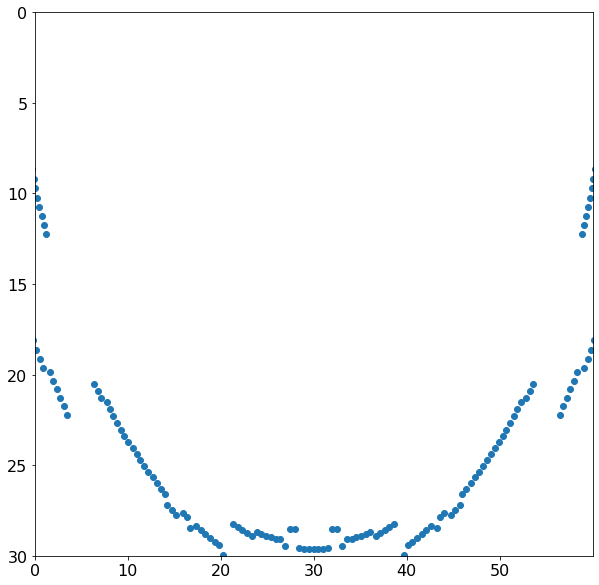

In [15]:
res3 = calculate_coordinates(posx=[0.5], angle=angles, distance=results[0], amplitude=results[1])
print(res2)

plt.xlim(0, model.domain_size[0] * 1e1)
plt.ylim(0, 30)
plt.gca().invert_yaxis()
plt.scatter(res2[:,0], res2[:,1])
plt.show()